In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

from yolov3 import YOLOv3, YOLOv3_Detection
from yolo_preprocess import Preprocessor
from yolo_postprocess import Postprocessor
import numpy as np

TOTAL_CLASSES = 20
BATCH_SIZE = 50

In [140]:
preprocess = Preprocessor(False, TOTAL_CLASSES, (416, 416))
dataset = tf.data.Dataset.list_files('./dataset/tfrecords/test_0001_of_0004.tfrecords')
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.map(preprocess, num_parallel_calls=1)
dataset = dataset.batch(BATCH_SIZE)
x, y_true = next(iter(dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


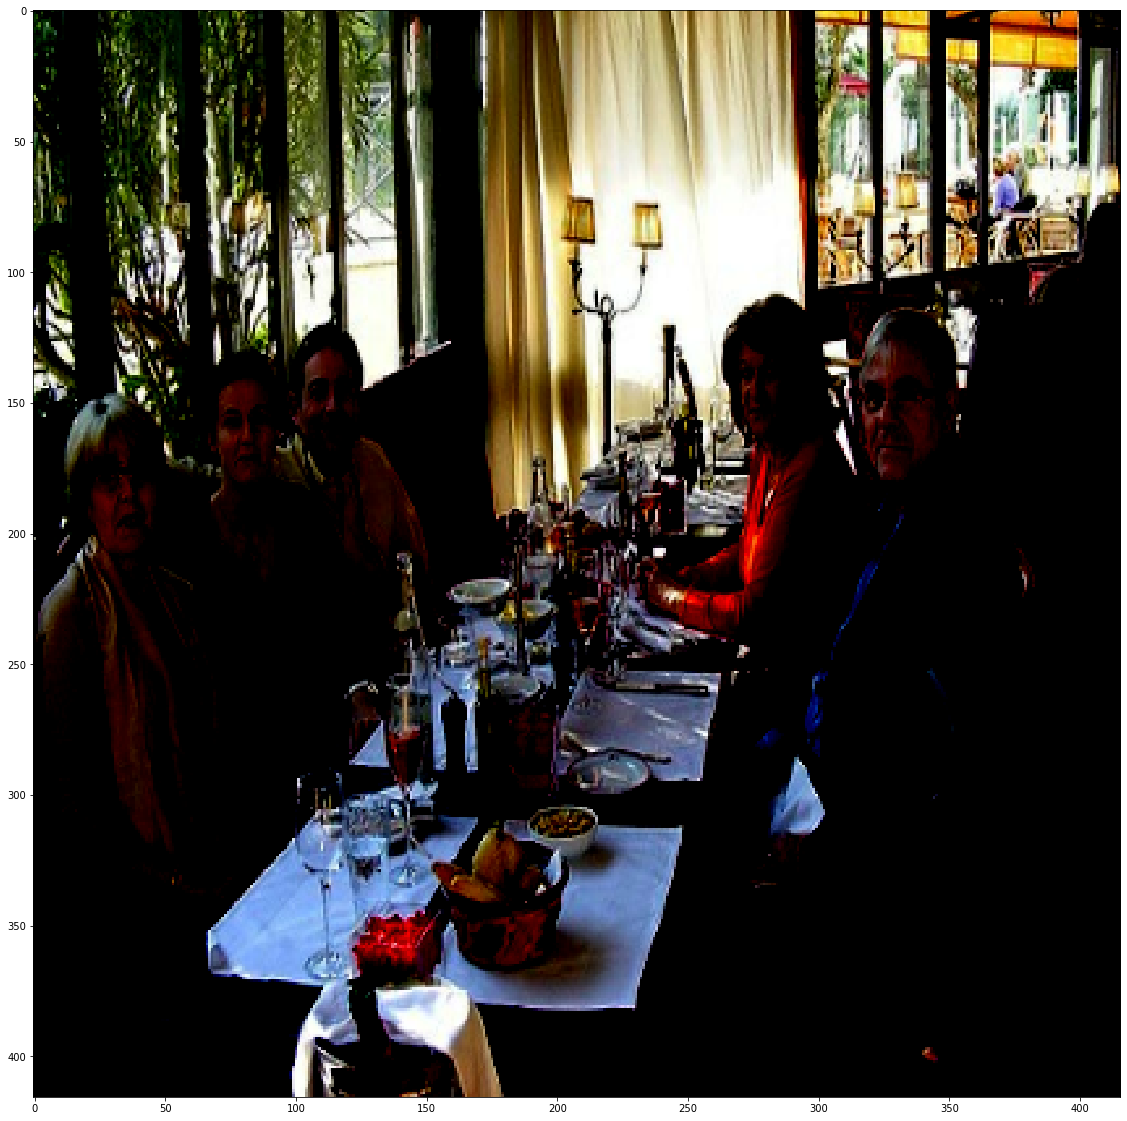

In [141]:
plt.imshow(x[27].numpy().reshape(416,416,3))

In [142]:
x = tf.reshape(x[27],(1,416,416,3))

In [5]:
class_names = {}
with open('./dataset/voc_2007_names.txt') as fp:
    lines = fp.read().splitlines()
    for i, line in enumerate(lines):
        class_names[i] = line


In [6]:
model = YOLOv3(shape=(416, 416, 3), num_classes=TOTAL_CLASSES)
model.load_weights('./models/model-v5.0.1-epoch-100-loss-24.4541.tf')

In [7]:
det = YOLOv3_Detection(model,num_classes=TOTAL_CLASSES)

In [143]:
postprocess = Postprocessor(iou_thresh=0.5, score_thresh=0.12)
y_pred = det(x, training=False)
y_pred_nms = postprocess(y_pred)

In [144]:
np.max(y_pred[2][1][...,0])

0.4495633

In [145]:
num_predictions = y_pred_nms[3][0][0].numpy()
print('Number of predictions: ', num_predictions)

Number of predictions:  11


In [146]:
np.argmax(y_pred_nms[2][0][0])

14

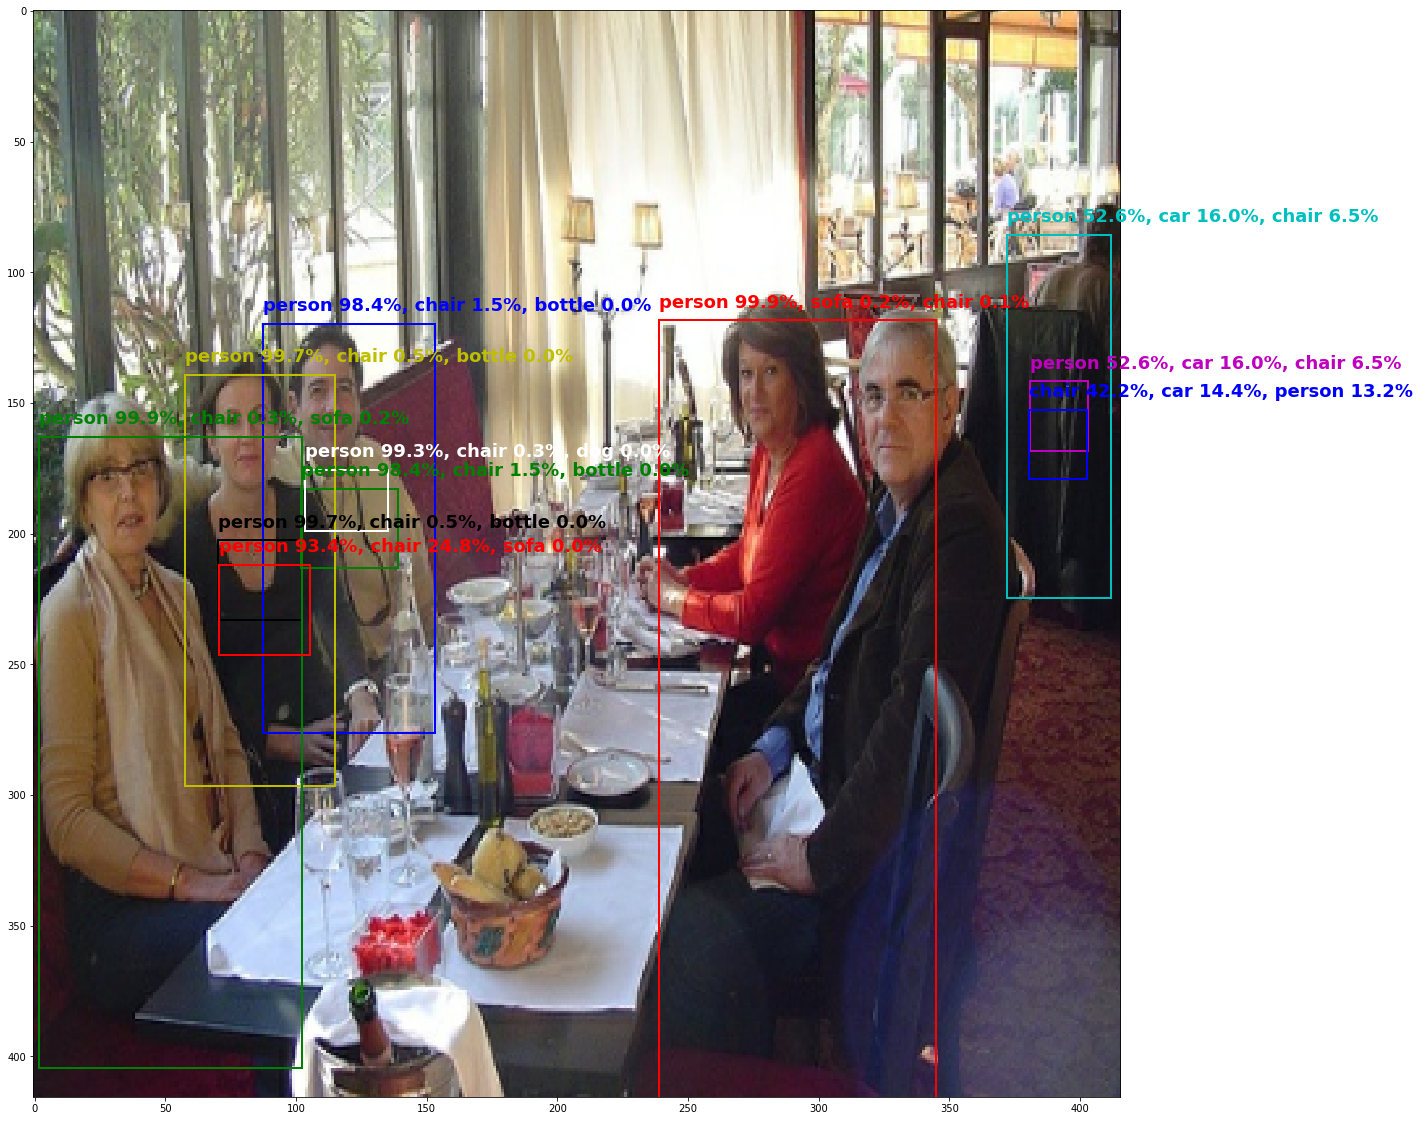

In [147]:

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
im = tf.cast((x[0] + 1) * 127.5, tf.int32)

plt.rcParams['figure.figsize'] = (20,20)
fig,ax = plt.subplots(1)
ax.imshow(im)
h, w, d = im.shape

for i in range(0, num_predictions):
    box = y_pred_nms[0][0][i].numpy()
    score = y_pred_nms[1][0][i][0].numpy()
    class_prob = y_pred_nms[2][0][i].numpy()
    values, indices = tf.math.top_k(class_prob, k=3)
    text= []
    for index, prob in zip(indices.numpy(), values.numpy()):
        text.append('{} {:.1f}%'.format(class_names[index], prob*100))
    text = ', '.join(text)
    xmin = box[0] * w
    ymin = box[1] * h
    width = (box[2] - box[0]) * w
    height = (box[3] - box[1]) * h
    color = colors[i % 8]
    rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor=color,facecolor='none')
    ax.add_patch(rect)
    ax.annotate(text, (xmin, ymin - 5), color=color, weight='bold', 
                fontsize=18)

plt.show()
